In [1]:
# a_eff
# d(e_orb)
# r_i
# r_ebind = a_eff * delta_eorb
# r_shred
# r_f = max(r_shred, r_ebind)

In [2]:
import mesa_reader as mr
import matplotlib.pylab as plt
import numpy as np
import os
import math
from math import log
from scipy.integrate import cumtrapz
import seaborn as sns

from ipynb.fs.full.profileFunctions import getMaxRadiusProfile
from ipynb.fs.full.functions import getConvZones
from ipynb.fs.full.EOrbFunctions import getEOrb
from ipynb.fs.full.EOrbFunctions import getOrbitalEnergyChange
from ipynb.fs.full.EBindFunctions import getEbind
from ipynb.fs.fullconvZoneFunctions import getConvZones

G = 6.67408e-11 # gravitational constant
# change G to cgs units
G = G * 1e3

In [3]:
directory = '/Users/emilyflynn/Desktop/25M_tests/15M_logs'
p15 = getMaxRadiusProfile(directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/20M_logs'
p20 = getMaxRadiusProfile(directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/25M_logs'
p25 = getMaxRadiusProfile(directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/30M_logs'
p30 = getMaxRadiusProfile(directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/40M_logs'
p40 = getMaxRadiusProfile(directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/50M_logs'
p50 = getMaxRadiusProfile(directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/60M_logs'
p60 = getMaxRadiusProfile(directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/70M_logs'
p70 = getMaxRadiusProfile(directory)

directory = '/Users/emilyflynn/Desktop/1.0M_Sun'
p1M = getMaxRadiusProfile(directory)

Looking for the profile closest to model #2050 in /Users/emilyflynn/Desktop/25M_tests/15M_logs
File path: /Users/emilyflynn/Desktop/25M_tests/15M_logs/profile48.data
Looking for the profile closest to model #2377 in /Users/emilyflynn/Desktop/25M_tests/20M_logs
File path: /Users/emilyflynn/Desktop/25M_tests/20M_logs/profile55.data
Looking for the profile closest to model #394 in /Users/emilyflynn/Desktop/25M_tests/25M_logs
File path: /Users/emilyflynn/Desktop/25M_tests/25M_logs/LOGS_to_si_burn/profile2.data
Looking for the profile closest to model #294 in /Users/emilyflynn/Desktop/25M_tests/30M_logs
File path: /Users/emilyflynn/Desktop/25M_tests/30M_logs/LOGS_before_remove/profile13.data
Looking for the profile closest to model #289 in /Users/emilyflynn/Desktop/25M_tests/40M_logs
File path: /Users/emilyflynn/Desktop/25M_tests/40M_logs/LOGS_before_remove/profile13.data
Looking for the profile closest to model #189 in /Users/emilyflynn/Desktop/25M_tests/50M_logs
File path: /Users/emilyfly

In [4]:
# categorize the zones into 1s or 0s
def booleanZones(zones):
    """Categorize the zones into 1s or 0s. 
    
    Keyword arguments:
    zones -- array of zones to be categorized
    """
    booleanZones = []
    for i in zones:
        if (i == 'removeLimited'):
            booleanZones.append(0)
        
        elif (i == 'removeNone'):
            booleanZones.append(1)
        
        else:
            booleanZones.append(1)
        
    return booleanZones

In [5]:
# I think this is good? need to ask Emily or Jason
def getEjectionEfficiency(p, m2, showWork):
    """Get the ejection efficiency.
    
    Keyword arguments:
    p -- MESA profile
    m2 -- mass of the secondary in Msun
    showWork -- print values or not
    """
    r = p.radius*69.551e9
    eOrb = getEOrb(p, m2)

    # get rf
    # find rshred
    from ipynb.fs.full.miscFunctions import getRShred
    rshred = getRShred(p, m2)

    # find the intersection of the ebind plot
    import numpy as np
    import matplotlib.pyplot as plt

    f = getOrbitalEnergyChange(p, m2)
    g = getEbind(p)

    r = r[:-1]
    f = f[:-1]

    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()

    # limit the values to between the max range and rshred
    rmax = p.radius[200]*69.551e9
    points = [ x for x in r[idx] if rshred <= x <= rmax ]

    rf = 0

    # if there's more than one point of intersection, use biggest
    if (len(points) > 1):
        points = max(points)
        rf = max(points, rshred)

    # no intersection
    elif (len(points) == 0):
        rf = rshred

    # one intersection
    else:
        rf = max(points[0], rshred)

    if showWork:
        print('r_final = ' + str(rf) + ' cm')
        plt.loglog(r, f)
        plt.loglog(r, g)
        plt.axvline(x=rshred, color='r', linestyle=':')
        plt.axvline(x=rmax, color='r', linestyle=':')
        plt.axvline(x=rf, color='g')


    # find ri
    ri = r[0]
    r = r[100:]
    
    if showWork:
        print('r_init = ' + str(ri) + ' cm')
        plt.axvline(x=ri, color='b')


    # denominator
    eOrb = eOrb[100:-1]
    eOrbi = eOrb[0]

    def findNearestIndex(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    # determine the index of the target radius
    index = findNearestIndex(r, rf)
    # apply that index to eOrb
    eOrbf = eOrb[index]

    denom = eOrbf - eOrbi


    # numerator
    dEOrb = np.diff(getEOrb(p, m2))
    radiusRef = p.radius*69.551e9
    idx1 = findNearestIndex(radiusRef, ri)
    idx2 = findNearestIndex(radiusRef, rf)
    num = dEOrb[idx2] - dEOrb[idx1]
    radiusRef = radiusRef[idx1:idx2]
    dEOrb = dEOrb[idx1:idx2]

    # need to do zones so that kind of sucks
    x, y = getConvZones(p, False, m2)
    idx1 = findNearestIndex(y, ri)
    idx2 = findNearestIndex(y, rf)
    x = x[idx1:idx2]

    # booleanZones
    zones = booleanZones(x)


    # make sure the lengths are the same
    dEOrb = dEOrb[100:]
    if(len(dEOrb) != len(zones)):
        if (len(dEOrb) > len(zones)):
            n = len(dEOrb) - len(zones)
            dEOrb = dEOrb[n:]
    
    # integration
    num = cumtrapz(dEOrb*zones)
    final = num / denom
#     finalEff = np.average(final)
    finalEff = final[len(final) - 1] # last item in array
    
    if showWork:
        print('a_eff = ' + str(finalEff))
        
    return finalEff

/Users/emilyflynn/anaconda3/lib/python3.7/site-packages/mesa_reader/__init__.py:335: RuntimeWarning: divide by zero encountered in log10
  return np.log10(self.bulk_data[self._exp10_version(key)])


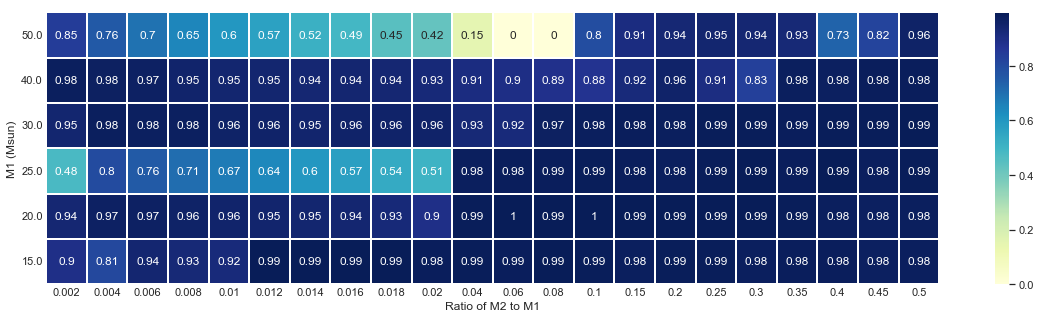

In [6]:
sns.set()

# p1s = [p15, p20, p25, p30, p40, p50, p60, p70, p1M]
p1s = [p15, p20, p25, p30, p40, p50]
m1s = []
for p in p1s:
    m1s.append(p.initial_mass)

m2ratios = [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
# m2ratios = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

vals = []

fig, ax = plt.subplots(figsize=(20, 5))

for p in p1s:
    y = []
    for m2ratio in m2ratios:
        m2 = m2ratio * p.initial_mass
        x = getEjectionEfficiency(p, m2, False)
        y.append(x)
    vals.append(y)

# print(vals)
# success! now have an array of efficiency values!
# rows are constant m1, columns are constant m2ratio

ax = sns.heatmap(vals, annot=True, linewidths=1, cmap="YlGnBu")

m2labels=[]
for m2 in m2ratios:
    m2labels.append(str(m2))
ax.set_xticklabels(m2labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")
plt.xlabel('Ratio of M2 to M1')

ax.set_yticklabels(m1s)
plt.setp(ax.get_yticklabels(), rotation=0, rotation_mode="anchor", va="center")
ax.invert_yaxis()
plt.ylabel('M1 (Msun)')

# hide the tick marks
ax.tick_params(axis=u'both', which=u'both',length=0)

# for 70M, expect all to be 0 but they're not